# Project 4, APS1070 Fall 2020
#### **Linear Regression -  20 points**
**Deadline: Nov 29, 23:59**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your name: **Ashutosh Desai**
*   Your student number: **1004774041**



## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import inv
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

1. Print the dataframe.
2. Prepare your dataset as follows: **[1]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.


In [ ]:
#Print the dataframe.
df

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13745,-53,-13,-0.07,0.02,0.58,-2.3,-15,12,0.022,-0.8,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,-0.001,0.0,0.5,0.019,-0.0007
13746,1,4,-0.11,-0.07,0.47,0.8,-5,8,-0.003,-0.2,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.016,-0.0004
13747,425,-14,0.40,0.07,0.41,-2.1,-16,12,0.031,-0.7,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.034,0.034,0.034,0.034,0.032,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.001,0.0,0.000,0.0,0.001,0.0,0.9,0.032,-0.0015
13748,102,-10,-0.19,0.08,1.30,0.5,-10,-3,-0.003,-0.2,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,1.4,0.051,-0.0015


In [ ]:
#Prepare your dataset

#Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set random_state=1.

X = df.copy()
X = X.drop(columns=['Goal'])
y = df['Goal']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #80:20 split of data

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(11000,1)
y_test = y_test.reshape(2750,1)

In [ ]:
y_train.shape

(11000, 1)

In [ ]:
#Standardize the data using StandardScaler from sklearn.

#Use the xtrain scalar for transforming both the xtest and xtrain @402
#No scaling the targets @380

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train) #fit xtrain to scaler
X_train_scaled = scaler.transform(X_train) #transform xtrain based on scaler
X_test_scaled = scaler.transform(X_test) #transform xtest based on scaler

In [ ]:
#Insert a first column of 1s in both the training and validation data sets.

X_train_new = np.hstack((np.ones((11000, 1)), X_train_scaled))
X_test_new = np.hstack((np.ones((2750, 1)), X_test_scaled))

print(X_train_new.shape)
print(X_test_new.shape)

(11000, 41)
(2750, 41)


## Part 2 - Linear Regression - Direct Solution [2 marks]

Implement the direct solution to linear regression on the training set. **[1]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[1]**

In [ ]:
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

In [ ]:
#Implement the direct solution to linear regression on the training set.

# analytical solution
W = np.dot(inv(np.dot(X_train_new.T, X_train_new)), np.dot(X_train_new.T, y_train))
W.shape

(41, 1)

In [ ]:
# Report the root-mean-square error (RMSE) for both the training and validation sets.

#Prediction and RMSE on the training set
print('Results for Linear Regression - Direct Solution: \n')
yPred_train = np.dot(X_train_new, W)
print('RMSE - Training Set: ', rmse(yPred_train, y_train))

#Prediction and RMSE on the validation set
yPred_test = np.dot(X_test_new, W)
print('RMSE - Validation Set: ', rmse(yPred_test, y_test))
rmse_ds_valid = rmse(yPred_test, y_test)

Results for Linear Regression - Direct Solution: 

RMSE - Training Set:  0.0001983241902503662
RMSE - Validation Set:  0.0001874084898605524


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's validation RMSE converges. Here we will consider it converged once validation RMSE is within 0.1% of the Direct Solution RMSE (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting - is running the algorithm too long a concern here? **[1]**

In [ ]:
#Calculating convergence threshold
CT = rmse_ds_valid*1.001
print('Convergence Threshold: ',CT)

Convergence Threshold:  0.00018759589835041292


In [ ]:
#Record the training time (from the first iteration until convergence) using the time.time() function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.

import time
start_time = time.time() ## Records current time

w1 = (np.random.random(41)).reshape(1,-1) ### Inital weights
w = w1/800
lr = 0.01  ### Learning rate
rmse_array_training = []
rmse_array_validation = []

for epoch in range (0, 6000): 
  ypred_train = np.dot(X_train_new,w.T).reshape (-1,1)
  ypred_test = np.dot(X_test_new,w.T).reshape (-1,1)
  
  rmse_array_training.append(rmse(ypred_train,y_train))
  rmse_array_validation.append(rmse(ypred_test,y_test))
  rmse_gd_valid = rmse(ypred_test,y_test)

  if rmse_gd_valid <= (rmse_ds_valid*1.001):
    epoch_threshold = epoch
    rmse_threshold = rmse_gd_valid
    break
  else:
      epoch_threshold = epoch
      rmse_threshold = rmse_gd_valid

  gradient = (1/len(ypred_train) * np.dot(X_train_new.T, ypred_train-y_train)).reshape(1,-1)
  w = w - lr * gradient ### weight update


print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

--- Total Training Time: 4.681676626205444 (s) ---


Epoch at threshold:  3410
RMSE validation at threshold (GD):  0.00018759564973990062


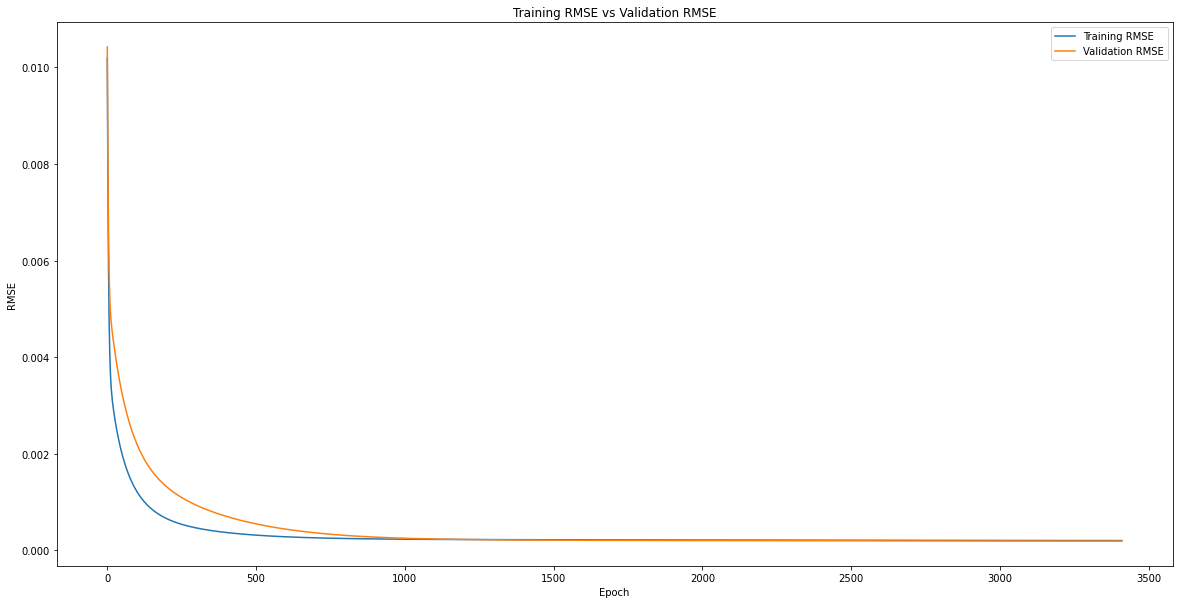

In [ ]:
#Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations)

print('Epoch at threshold: ',epoch_threshold)
print('RMSE validation at threshold (GD): ',rmse_threshold)
plt.figure(figsize=(20,10))
plt.plot(rmse_array_training, label = 'Training RMSE')
plt.plot(rmse_array_validation, label = 'Validation RMSE')
plt.title("Training RMSE vs Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

**Q.** Comment on overfitting/underfitting - is running the algorithm too long a concern here?

**A.** The graph shown above displays the trend of 'Traininf RMSE' and 'Validation RMSE' per epoch for a full-batch gradient descent method. Initially, the random weights have a high training and testing error. However, both the training RMSE & testing RMSE, converge to the Convergence threshold much before the maximum number of epoch set in the code.


It can be concluded that it is a good fit to the training data because both the training and testing RMSE values are at their lowest. In order to let the algorithm run for a longer time, the number of epochs need to be increased to a very high number (much greater than 6000). However, we observe that the model reaches its convergence much before that. Thus, the running of the algorithm too long shall **not** be a concern.

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached.**[1]** The inputs of that function are 
  * Training Data
  * Validation Data
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)
  * Maximum Iterations = 20000

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds the array would look like: [2 4 6 8 ...]).
 * For certain batchsizes GD might not converge to a solution. For that reason we have a parameter "Maximum iterations" where we limit the total number of iterations that this function can perform. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (ie all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batchsizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeawyas from each of your plots. **[1]**

In [ ]:
#Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached

def mini_batch_gradient_descent(X_train_new,X_test_new,bs,lr,CT,max_iterations):
  import time
  start_time = time.time() ## Records current time

  #w1 = (np.random.random(41)).reshape(1,-1) ### Inital weights
  w = w1/800

  rmse_array_training = []
  rmse_array_validation = []
  time_per_epoch = []

  iter = int(len(X_train_new) / bs)
  epochs = max_iterations / iter
  epochs = int(epochs)
  epoch_threshold = 0
  rmse_threshold = 0

  for epoch in range(1,epochs+2):
    for i in range(1,iter+1):
      ypred_train = np.dot(X_train_new[((i-1)*bs):(i*bs)],w.T).reshape (-1,1)
      gradient = (1/len(ypred_train) * np.dot(X_train_new[((i-1)*bs):(i*bs)].T, ypred_train-y_train[((i-1)*bs):(i*bs)])).reshape(1,-1)
      w = w - lr * gradient ### weight update
    
    if len(X_train_new[iter*bs:]) != 0:
      ypred_train = np.dot(X_train_new[iter*bs:],w.T).reshape (-1,1)
      gradient = (1/len(ypred_train) * np.dot(X_train_new[iter*bs:].T, ypred_train-y_train[iter*bs:])).reshape(1,-1)
      w = w - lr * gradient ### weight update
    
    ypred_train_per_epoch = np.dot(X_train_new,w.T).reshape (-1,1)
    ypred_test_per_epoch = np.dot(X_test_new,w.T).reshape (-1,1)

    rmse_array_training.append(rmse(ypred_train_per_epoch,y_train))
    rmse_array_validation.append(rmse(ypred_test_per_epoch,y_test))
    
    rmse_gd_valid = rmse(ypred_test_per_epoch,y_test)

    time_per_epoch.append(time.time() - start_time)

    if rmse_gd_valid <= CT:
      epoch_threshold = epoch
      rmse_threshold = rmse_gd_valid
      break
    else:
      epoch_threshold = epoch
      rmse_threshold = rmse_gd_valid
    
  return w,rmse_array_training,rmse_array_validation,time_per_epoch,epoch_threshold,rmse_threshold
    

In [ ]:
#Testing the function

a,b,c,d,e,f = mini_batch_gradient_descent(X_train_new,X_test_new,11000,0.01,CT,20000)
#print(b)
#print(c)
print(max(d))
print(f)
print(e)

4.845832347869873
0.00018759564973990062
3410


In [ ]:
#Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of α=1e−2. Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...). These batchsizes fit better on the hardware and may achieve higher performance.

#Making a list of different batch sizes
bs = []
for i in range (0,12):
  bs.append(2**i)
print('Different batch sizes: ',bs)

lr = 0.01
print('Learning rate: ',lr)

Different batch sizes:  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Learning rate:  0.01


<function matplotlib.pyplot.show>

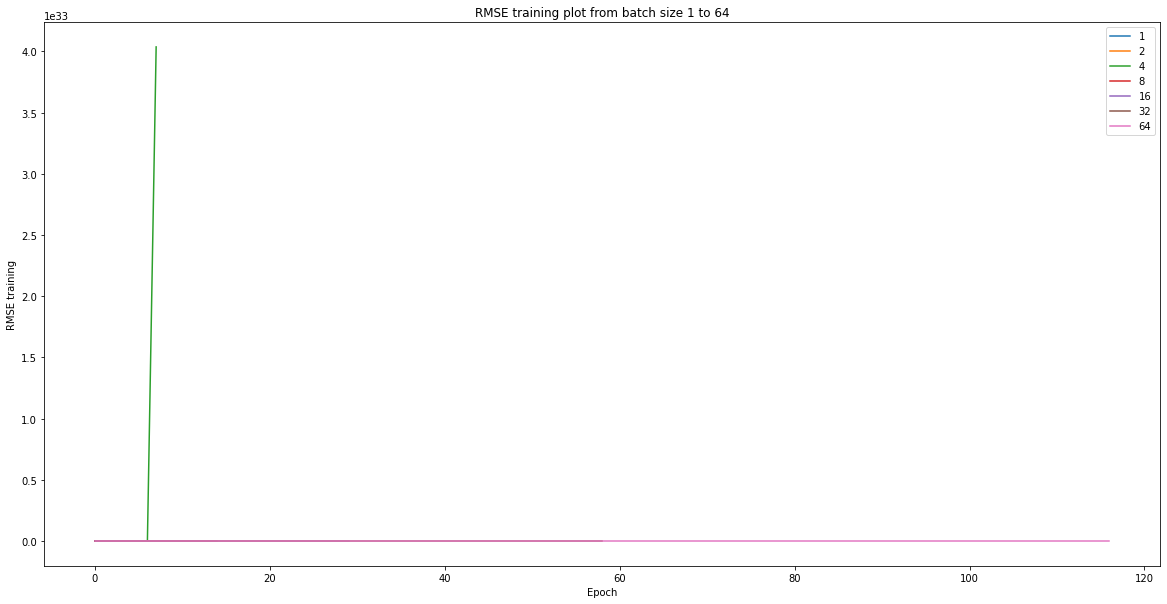

In [ ]:
#Plot TRAINING RMSE vs. epoch for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE.
#Diverging errors
plt.figure(figsize=(20,10))
for i in bs[:7]:
  _,b,_,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  
  plt.plot(b, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE training")

plt.legend()
plt.title("RMSE training plot from batch size 1 to 64")
plt.show

For mini-batch gradient descent, the training RMSE of batch sizes 1-64 diverge, and thus are plotted on a separate graph. The training error for batch size 4 shoots very high somewhere between epoch 0 and 20.

<function matplotlib.pyplot.show>

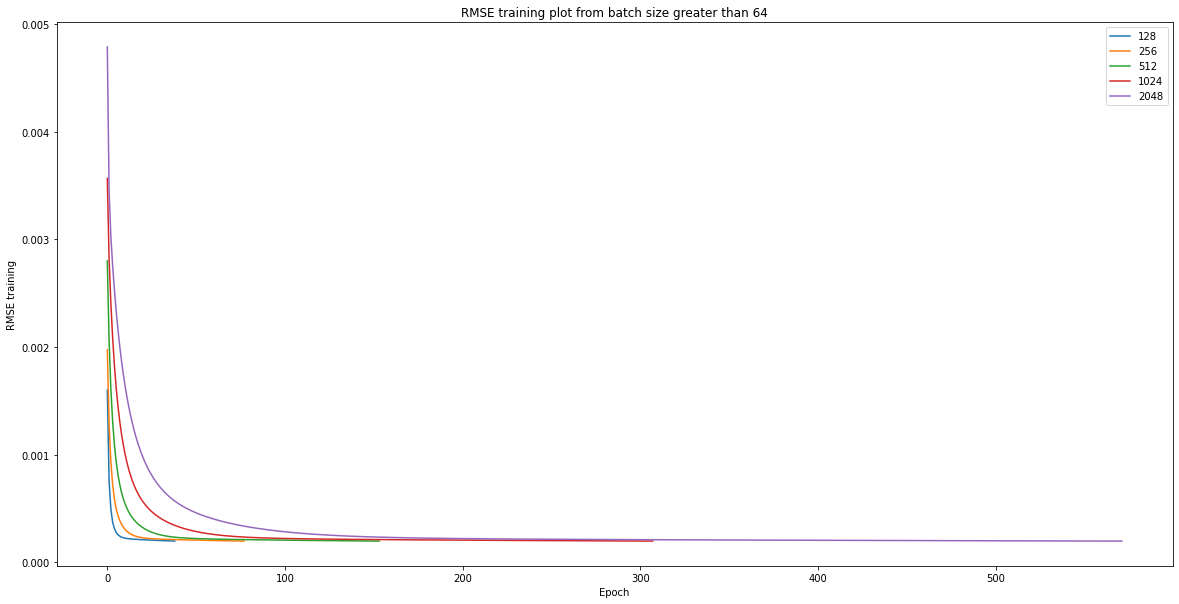

In [ ]:
##Plot TRAINING RMSE vs. epoch for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE.
#Converging errors
plt.figure(figsize=(20,10))
for i in bs[7:]:
  _,b,_,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(b, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE training")
plt.legend()
plt.title("RMSE training plot from batch size greater than 64")
plt.show

For mini-batch gradient descent, the training RMSE of batch sizes 128-2048 converge, and thus are plotted on a separate graph. It can be observed that batch size 128, takes the least number of epochs for a particular learning rate.

<function matplotlib.pyplot.show>

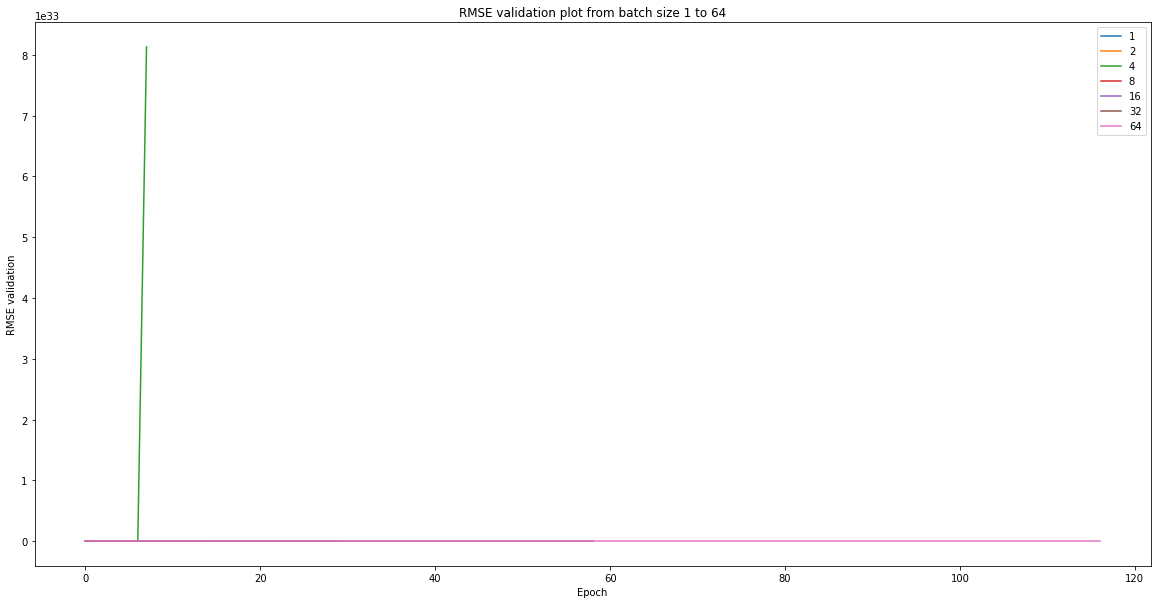

In [ ]:
#Plot VALIDATION RMSE vs. epoch for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE.
#Diverging errors (from batch 1 to 64)
plt.figure(figsize=(20,10))
for i in bs[:7]:
  _,_,c,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(c, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot from batch size 1 to 64")
plt.show

Similar observations for the validation set as the training set.


<function matplotlib.pyplot.show>

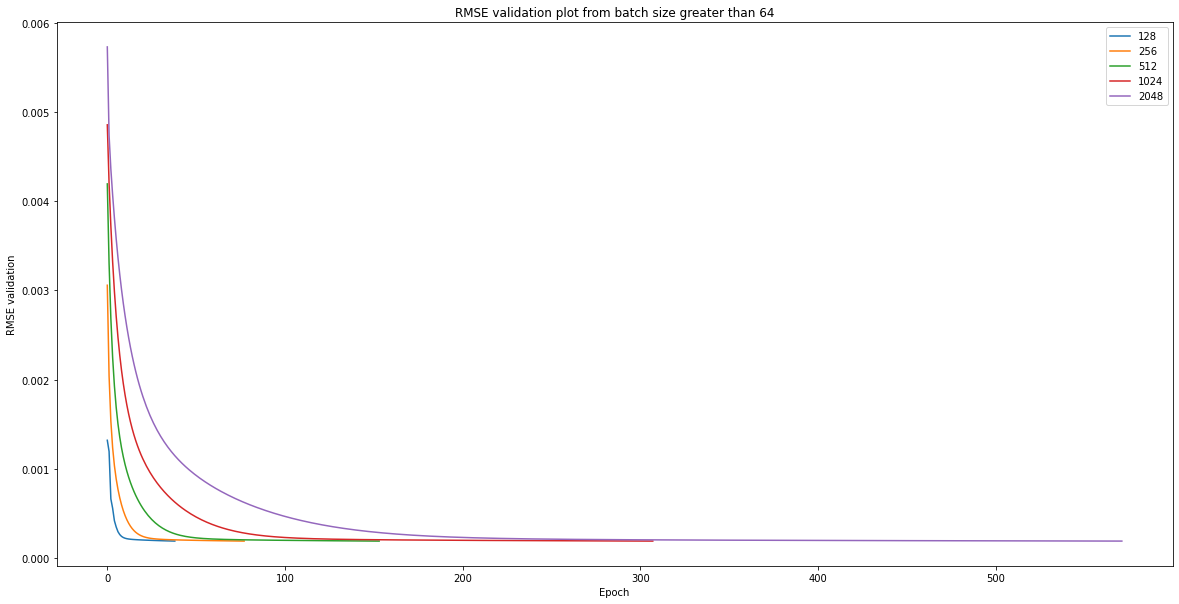

In [ ]:
##Plot VALIDATION RMSE vs. epoch for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE.
#Converging errors
plt.figure(figsize=(20,10))
for i in bs[7:]:
  _,_,c,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(c, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot from batch size greater than 64")
plt.show

Similar observations for the validation set as the training set.

<function matplotlib.pyplot.show>

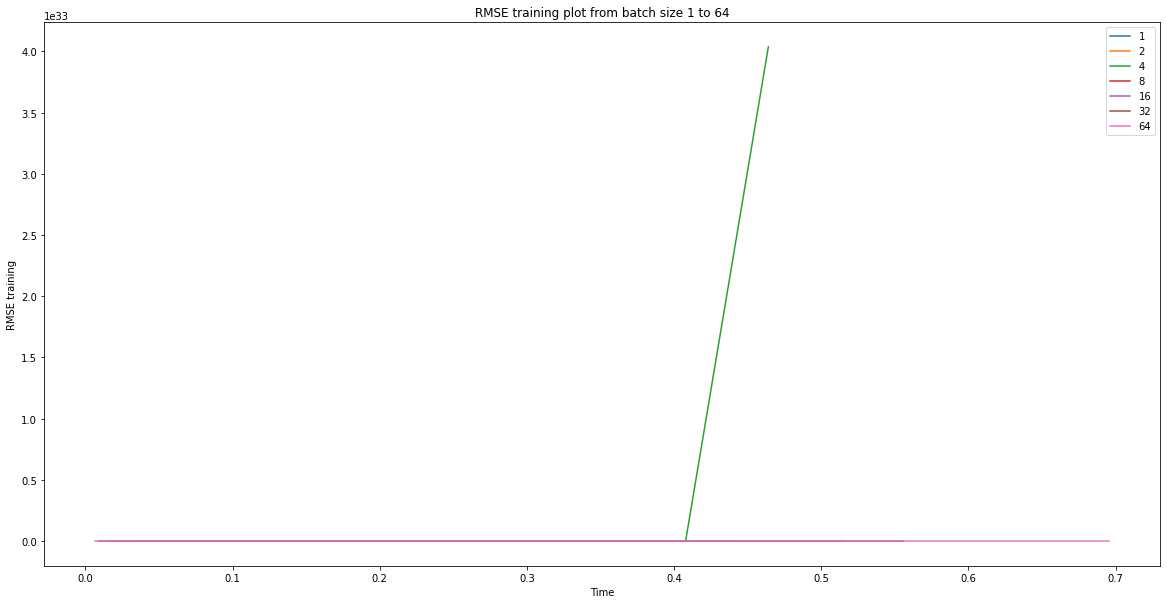

In [ ]:
#Plot TRAINING RMSE vs. time for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE.
#Diverging errors
plt.figure(figsize=(20,10))
for i in bs[:7]:
  _,b,_,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(d,b, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE training")
plt.legend()
plt.title("RMSE training plot from batch size 1 to 64")
plt.show

This plot is for the batch size range from 1-64. The plot is between time taken per epoch vs RMSE training per epoch. Batcg size 4 has the maximum error.

<function matplotlib.pyplot.show>

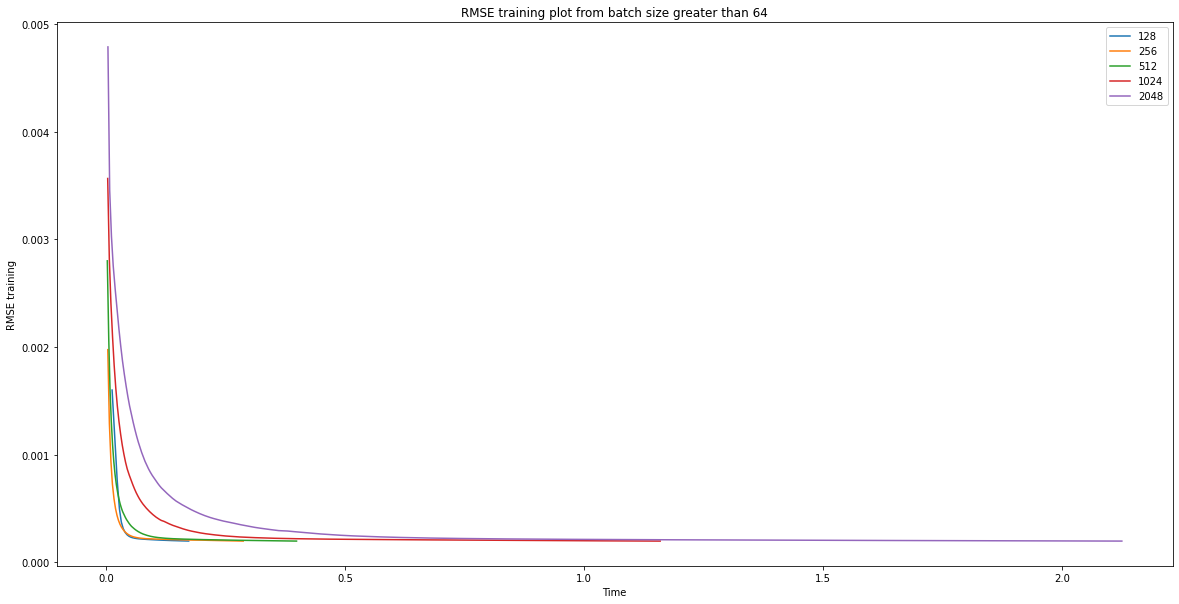

In [ ]:
#Converging errors
plt.figure(figsize=(20,10))
for i in bs[7:]:
  _,b,_,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(d,b, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE training")
plt.legend()
plt.title("RMSE training plot from batch size greater than 64")
plt.show

This x-axis represents the RMSE training per epoch and y-axis represents time taken per epoch. The different color lines represent different batch sizes from 128-2048. It can be concluded that batch size 128 converges in the least amount of time for a particular value of learning rate.

<function matplotlib.pyplot.show>

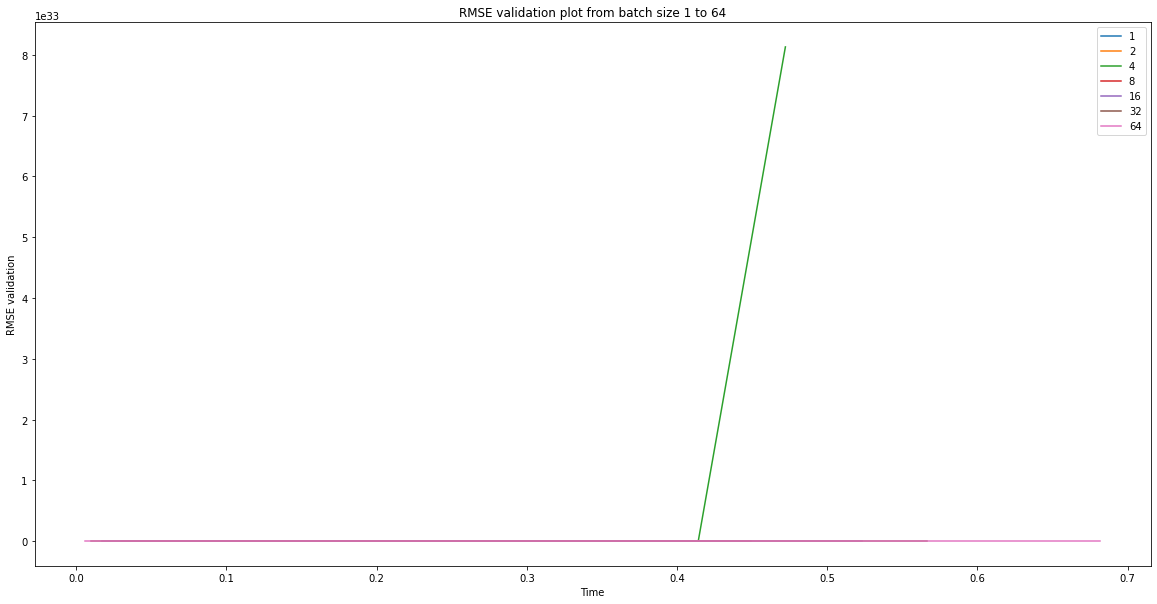

In [ ]:
#Plot VALIDATION RMSE vs. time for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE.
#Diverging errors (from batch 1 to 64)
plt.figure(figsize=(20,10))
for i in bs[:7]:
  _,_,c,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(d,c, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot from batch size 1 to 64")
plt.show

Observations are similar to the training data.

<function matplotlib.pyplot.show>

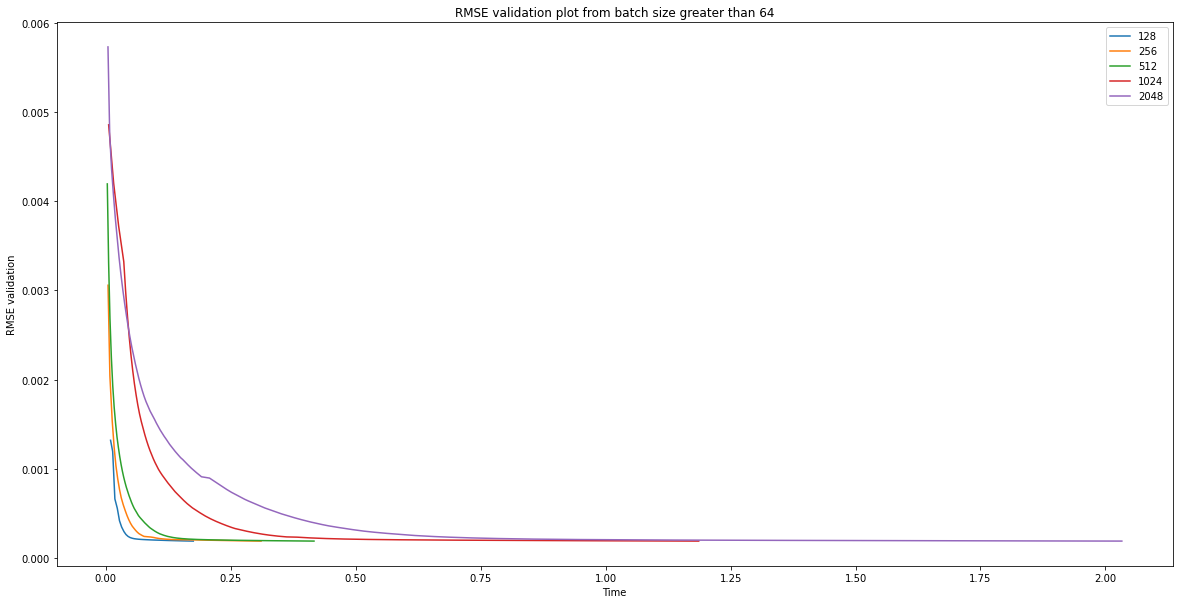

In [ ]:
#Converging errors
plt.figure(figsize=(20,10))
for i in bs[7:]:
  _,_,c,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  plt.plot(d,c, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot from batch size greater than 64")
plt.show

Observstions are similar to the training data.

In [ ]:
#Plot Total training time (y-axis) vs. Batch size (x-axis).

ttime1 = []
ttime2 = []
for i in bs[:7]:
  _,_,_,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  ttime1.append(max(d))

for i in bs[7:]:
  _,_,_,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,i,lr,CT,20000)
  ttime2.append(max(d))

print(ttime1)
print(bs[:7])

print(ttime2)
print(bs[7:])

[0.2363595962524414, 0.4197666645050049, 0.4847683906555176, 0.4587860107421875, 0.5106120109558105, 0.6058087348937988, 0.7629683017730713]
[1, 2, 4, 8, 16, 32, 64]
[0.1787421703338623, 0.27923011779785156, 0.4065549373626709, 1.1141324043273926, 2.109611988067627]
[128, 256, 512, 1024, 2048]


<function matplotlib.pyplot.show>

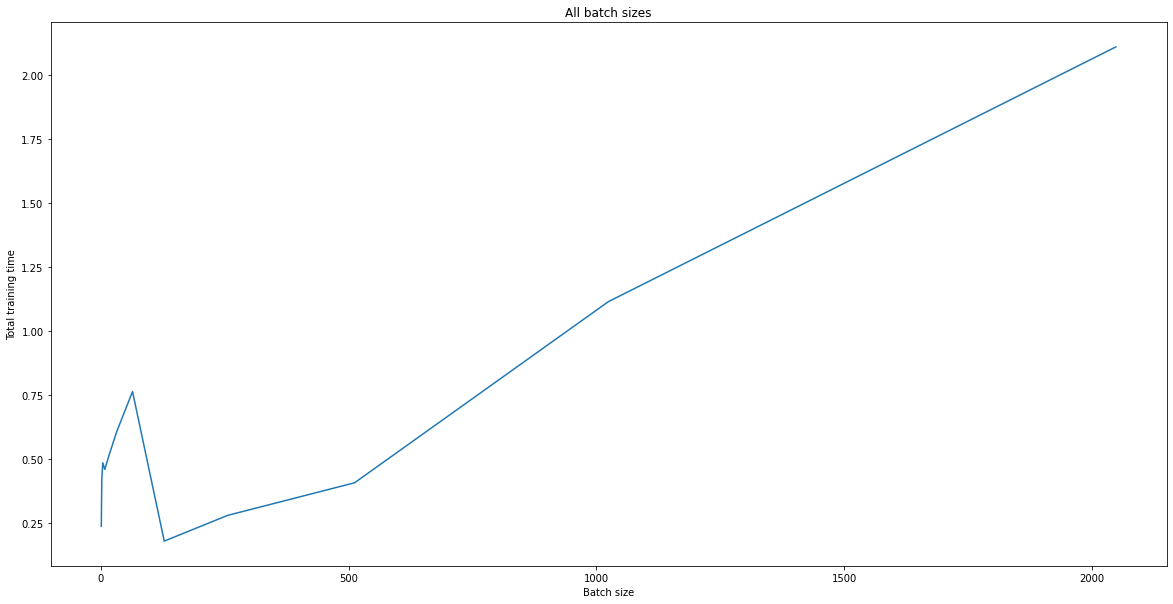

In [ ]:
#plotting the data
plt.figure(figsize=(20,10))
plt.plot(bs, ttime1+ttime2)
plt.xlabel("Batch size")
plt.ylabel("Total training time")
plt.title("All batch sizes")
plt.show

The mini-batch gradient descent method used in this section is to determine the best batch size.

1. Plot of RMSE training vs epoch - **128 batch size converging at lowest epoch**.
2. Plot of RMSE validation vs epoch - **128 batch size converging at lowest epoch**.
3. Plot of RMSE training per epoch vs time taken per epoch - **128 batch size converging the fastest**.
4. Plot of RMSE validation per epoch vs time taken per epoch - **128 batch size converging the fastest**.


BEST BATCH SIZE = **128**

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD. 
  1. Plot the training and validation RMSE vs **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  2. Plot the training and validation RMSE vs **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  3. Describe your findings, including the main takeawyas from each of your plots. **[1]**


<function matplotlib.pyplot.show>

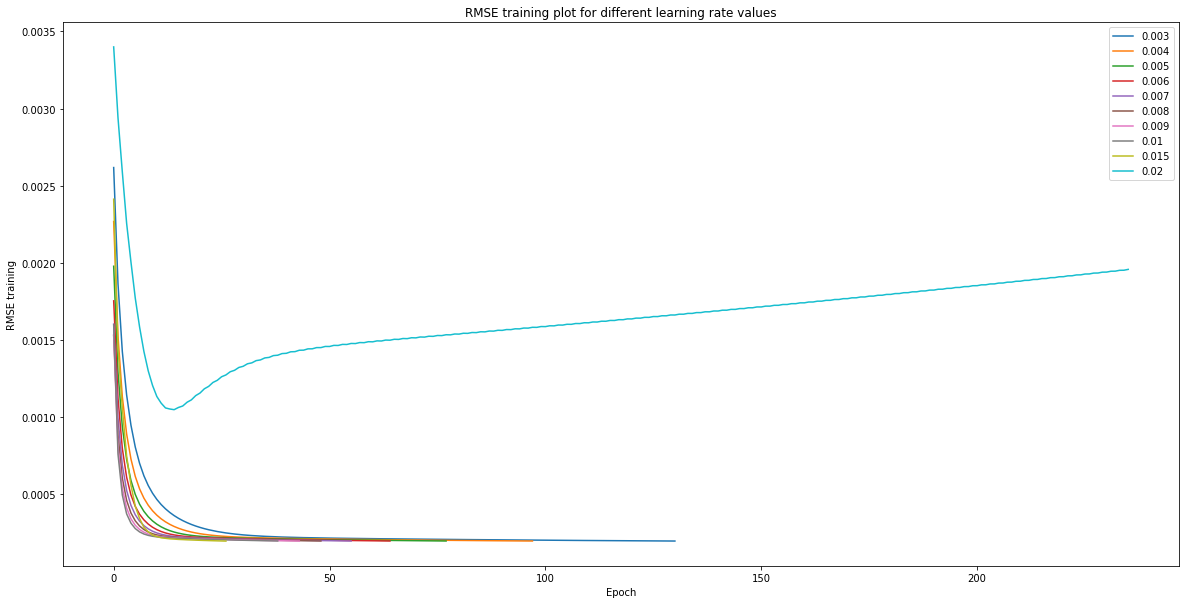

In [ ]:
#Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD.

bs = 128
lr = [0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.015,0.02]

#Plot the training RMSE vs epoch (x-axis) for all the learning rates that you tried in a figure.
plt.figure(figsize=(20,10))
for i in lr:
  _,b,_,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,bs,i,CT,20000)
  plt.plot(b, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE training")
plt.legend()
plt.title("RMSE training plot for different learning rate values")
plt.show

Mini-batch gradient descent function is used to plot RMSE training vs epoch for different learning rates having fixed the batch size as 128. Yellow line (0.015) converges at least number of epochs.

<function matplotlib.pyplot.show>

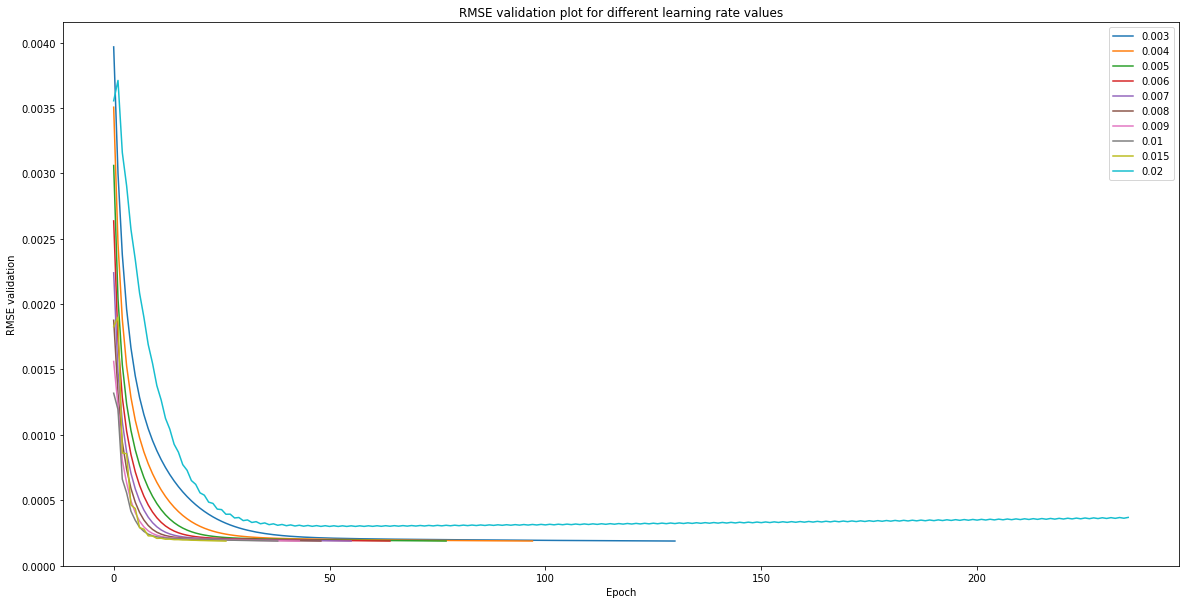

In [ ]:
#Plot the validation RMSE vs epoch (x-axis) for all the learning rates that you tried in a figure.
plt.figure(figsize=(20,10))
for i in lr:
  _,_,c,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,bs,i,CT,20000)
  plt.plot(c, label = str(i))
  plt.xlabel("Epoch")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot for different learning rate values")
plt.show

Mini-batch gradient descent function is used to plot RMSE validation vs epoch
for different learning rates having fixed the batch size as 128. Yellow line (0.015) converges atleast number of epochs.

<function matplotlib.pyplot.show>

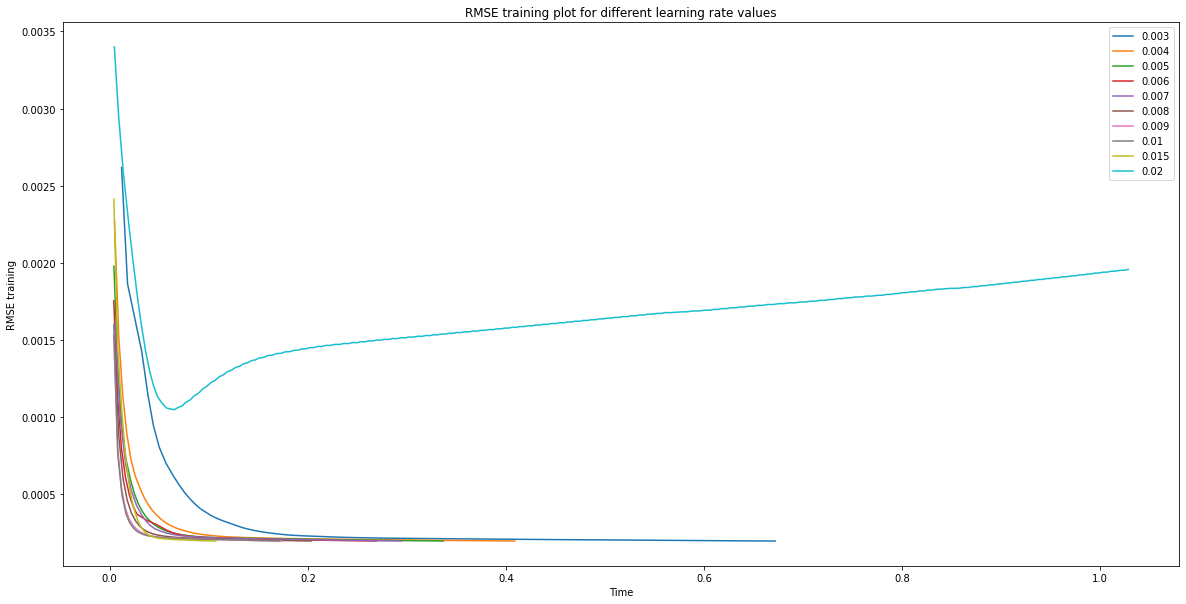

In [ ]:
#Plot the training RMSE vs time (x-axis) for all the learning rates that you tried in a figure
plt.figure(figsize=(20,10))
for i in lr:
  _,b,_,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,bs,i,CT,20000)
  plt.plot(d,b, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE training")
plt.legend()
plt.title("RMSE training plot for different learning rate values")
plt.show

Mini-batch gradient descent function is used to plot RMSE training per epoch vs time taken pe epoch for different learning rates having fixed the batch size as 128. Yellow line (0.015) converges the fastest.

<function matplotlib.pyplot.show>

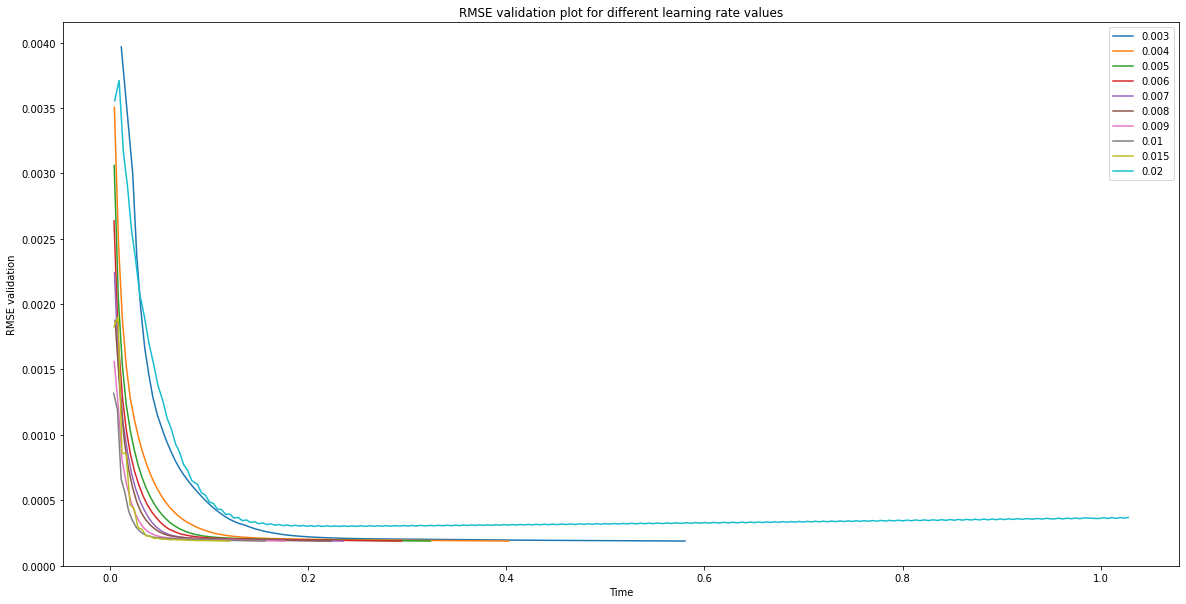

In [ ]:
#Plot the validation RMSE vs time (x-axis) for all the learning rates that you tried in a figure
plt.figure(figsize=(20,10))
for i in lr:
  _,_,c,d,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,bs,i,CT,20000)
  plt.plot(d,c, label = str(i))
  plt.xlabel("Time")
  plt.ylabel("RMSE validation")
plt.legend()
plt.title("RMSE validation plot for different learning rate values")
plt.show

Mini-batch gradient descent function is used to plot RMSE training per epoch vs time taken pe epoch for different learning rates having fixed the batch size as 128. Yellow line (0.015) converges the fastest.

**Q.** Describe your findings, including the main takeawyas from each of your plots

**A.** The mini-batch gradient descent method used in this section is to determine the best batch size.

1. Plot of RMSE training vs epoch - **0.015 learning rate converging at lowest epoch**.
2. Plot of RMSE validation vs epoch - **0.015 learning rate converging at lowest epoch**.
3. Plot of RMSE training per epoch vs time taken per epoch - **0.015 learning rate converging the fastest**.
4. Plot of RMSE validation per epoch vs time taken per epoch - **0.015 learning rate converging the fastest**.


BEST STATIC LEARNING RATE = **0.015**

## Part 6 - Gradient Descent with Adaptive Learning Rate [4 marks]
Implement an adaptive learning rate scheme where you start a mini-batch gradient descent with a large learning rate and decrease the learning rate while you are getting closer to the local minima. It's up to you to come up with a way to set **when** and **how much** do you want to change the learning rate. 
Our goal is to find a method for faster convergence. 
  1. Describe **[1]** and implement **[1]** your method.
  2. Plot the training and validation RMSE vs **epoch** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**
  3. Plot the training and validation RMSE vs **time** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**

**Q.** Describe your method

**A.** In this method we use Adaptive learning rate in Gradient descent method (mini-batch). The highest initial learning rate is taken by the function as input (the highest value at which the function converges the error).

The value of the learning rate keeps reducing per epoch for a particular batch size. The step size of learning rate change is not constant in order to avoid the RMSE to diverge when it comes closer to the minima. The new learning rate is equal to **LR / (1+LR)**. This way as the learning rate decreses with every epoch, the step size also keeps decreasing letting the model to converge with comfort when approaching the minima. With the change of the learning rate after each epoch, the validation RMSE is checked. The function returns its results when the validation RMSE crosses the Convergence Threshold.

In [ ]:
#Implement your method.
#Write a function that performs Gradient Descent with Adaptive Learning Rate until the convergence threshold (CT) is reached

def adaptive_learning_gd(X_train_new,X_test_new,bs,learn_rate,CT,max_iterations):
  import time
  start_time = time.time() ## Records current time

  #w1 = (np.random.random(41)).reshape(1,-1) ### Inital weights
  w = w1/800

  lr = learn_rate


  rmse_array_training = []
  rmse_array_validation = []
  time_per_epoch = []
  lr_per_epoch = []

  iter = int(len(X_train_new) / bs)
  epochs = max_iterations / iter
  epochs = int(epochs)
  epoch_threshold = 0
  rmse_threshold = 0

  for epoch in range(1,epochs+2):
    for i in range(1,iter+1):
      ypred_train = np.dot(X_train_new[((i-1)*bs):(i*bs)],w.T).reshape (-1,1)
      gradient = (1/len(ypred_train) * np.dot(X_train_new[((i-1)*bs):(i*bs)].T, ypred_train-y_train[((i-1)*bs):(i*bs)])).reshape(1,-1)
      w = w - lr * gradient ### weight update
    
    if len(X_train_new[iter*bs:]) != 0:
      ypred_train = np.dot(X_train_new[iter*bs:],w.T).reshape (-1,1)
      gradient = (1/len(ypred_train) * np.dot(X_train_new[iter*bs:].T, ypred_train-y_train[iter*bs:])).reshape(1,-1)
      w = w - lr * gradient ### weight update
    
    ypred_train_per_epoch = np.dot(X_train_new,w.T).reshape (-1,1)
    ypred_test_per_epoch = np.dot(X_test_new,w.T).reshape (-1,1)

    rmse_array_training.append(rmse(ypred_train_per_epoch,y_train))
    rmse_array_validation.append(rmse(ypred_test_per_epoch,y_test))
    
    rmse_gd_valid = rmse(ypred_test_per_epoch,y_test)

    time_per_epoch.append(time.time() - start_time)
    lr_per_epoch.append(lr)
    
    lr = lr/(1+lr)

    if rmse_gd_valid <= CT:
      epoch_threshold = epoch
      rmse_threshold = rmse_gd_valid
      break
    else:
      epoch_threshold = epoch
      rmse_threshold = rmse_gd_valid
    
  return w,rmse_array_training,rmse_array_validation,time_per_epoch,epoch_threshold,rmse_threshold,lr_per_epoch

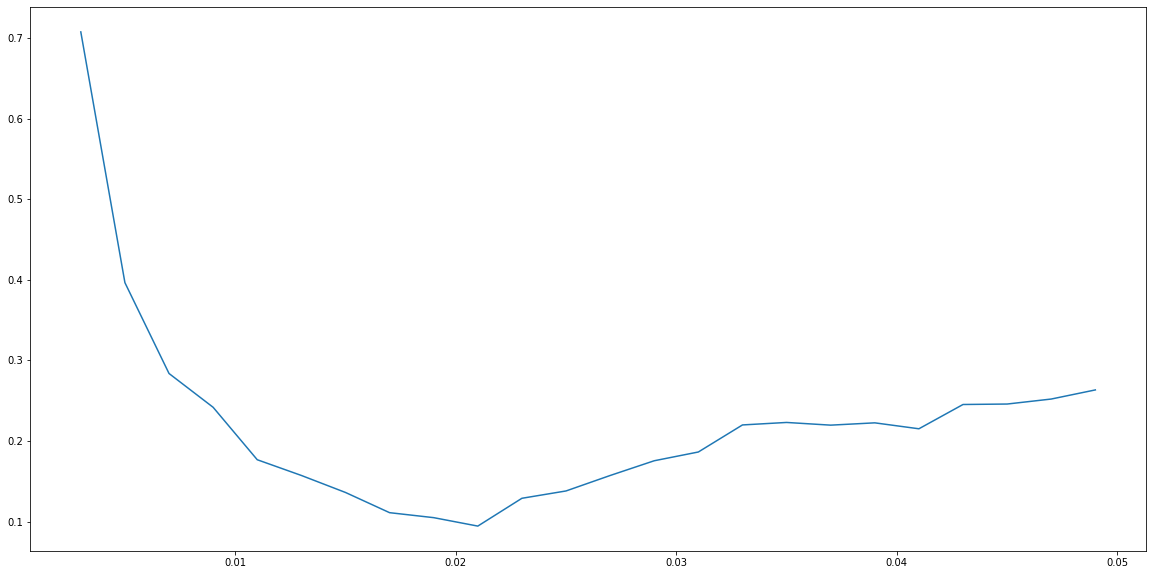

In [ ]:
#Selecting the best learning rate to begin the adaptive learning function in order to achieve the best time.
d_t = []
list1 = np.arange(0.003,0.05,0.002).tolist()
plt.figure(figsize=(20,10))
for i in list1:

  a,b,c,d,e,f,g = adaptive_learning_gd(X_train_new,X_test_new,128,i,CT,20000)
  d_t.append(max(d))

plt.plot(list1,d_t,label='time vs lr')
plt.show()
  
  

Best initial learning rate for Gradient Descent with Adaptive Learning Rate = 0.023 

<function matplotlib.pyplot.show>

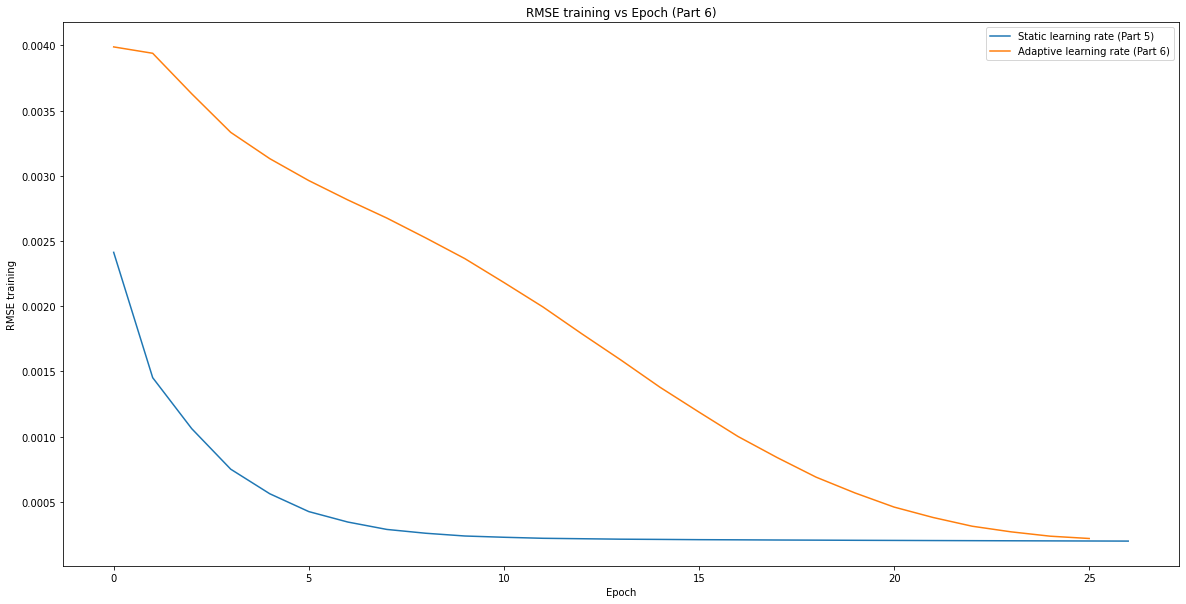

In [ ]:
#Plot the training and validation RMSE vs epoch for your method
lr = 0.023
plt.figure(figsize=(20,10))
_,b1,_,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,128,0.015,CT,20000)
plt.plot(b1, label = 'Static learning rate (Part 5)')

_,b2,_,_,_,_,_ = adaptive_learning_gd(X_train_new,X_test_new,128,lr,CT,20000)
plt.plot(b2, label = 'Adaptive learning rate (Part 6)')
plt.xlabel('Epoch')
plt.ylabel('RMSE training')
plt.title('RMSE training vs Epoch (Part 6)')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

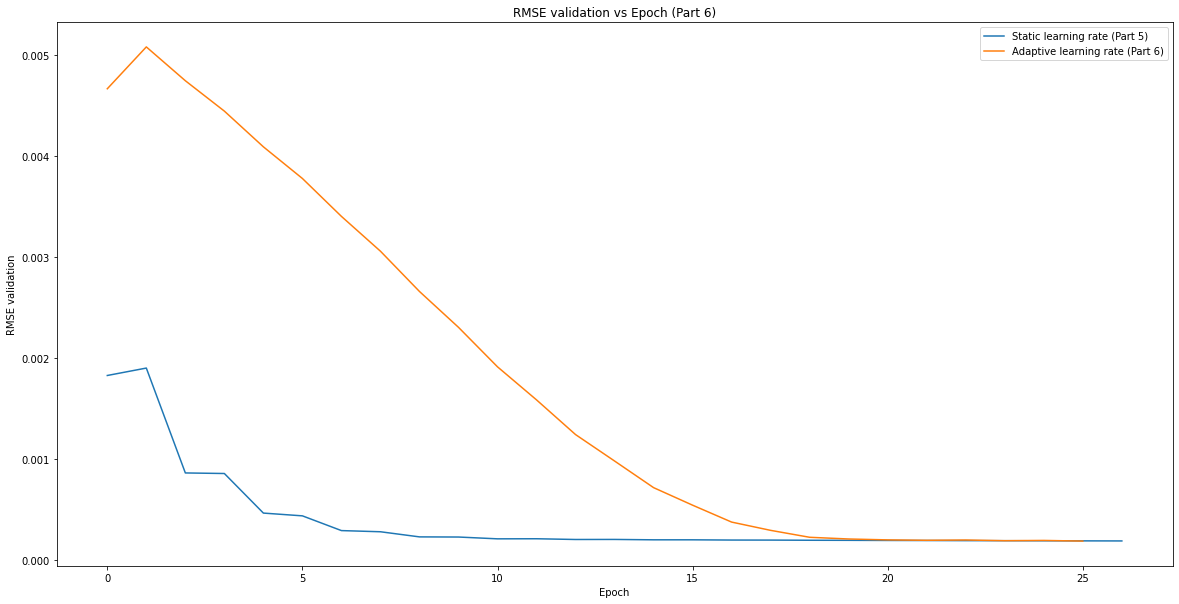

In [ ]:
#Plot the training and validation RMSE vs epoch for your method
plt.figure(figsize=(20,10))
_,_,c1,_,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,128,0.015,CT,20000)
plt.plot(c1, label = 'Static learning rate (Part 5)')

_,_,c2,_,_,_,_ = adaptive_learning_gd(X_train_new,X_test_new,128,lr,CT,20000)
plt.plot(c2, label = 'Adaptive learning rate (Part 6)')
plt.xlabel('Epoch')
plt.ylabel('RMSE validation')
plt.title('RMSE validation vs Epoch (Part 6)')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

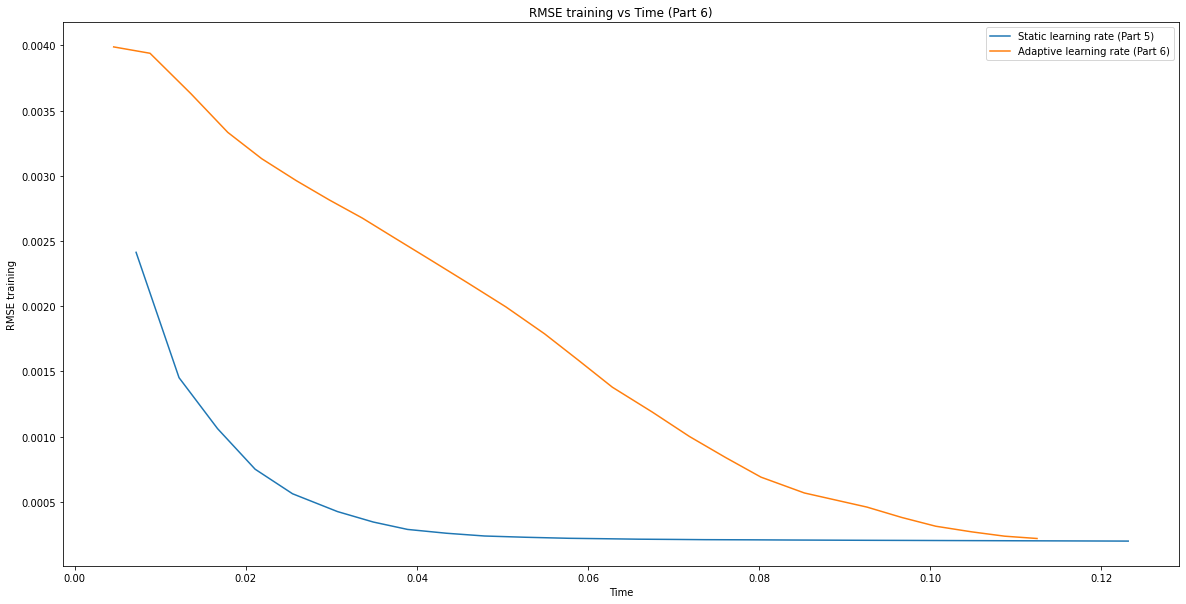

In [ ]:
#Plot the training and validation RMSE vs time for your method
plt.figure(figsize=(20,10))
_,b1,_,d1,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,128,0.015,CT,20000)
plt.plot(d1,b1, label = 'Static learning rate (Part 5)')

_,b2,_,d2,_,_,_ = adaptive_learning_gd(X_train_new,X_test_new,128,lr,CT,20000)
plt.plot(d2,b2, label = 'Adaptive learning rate (Part 6)')
plt.xlabel('Time')
plt.ylabel('RMSE training')
plt.title('RMSE training vs Time (Part 6)')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

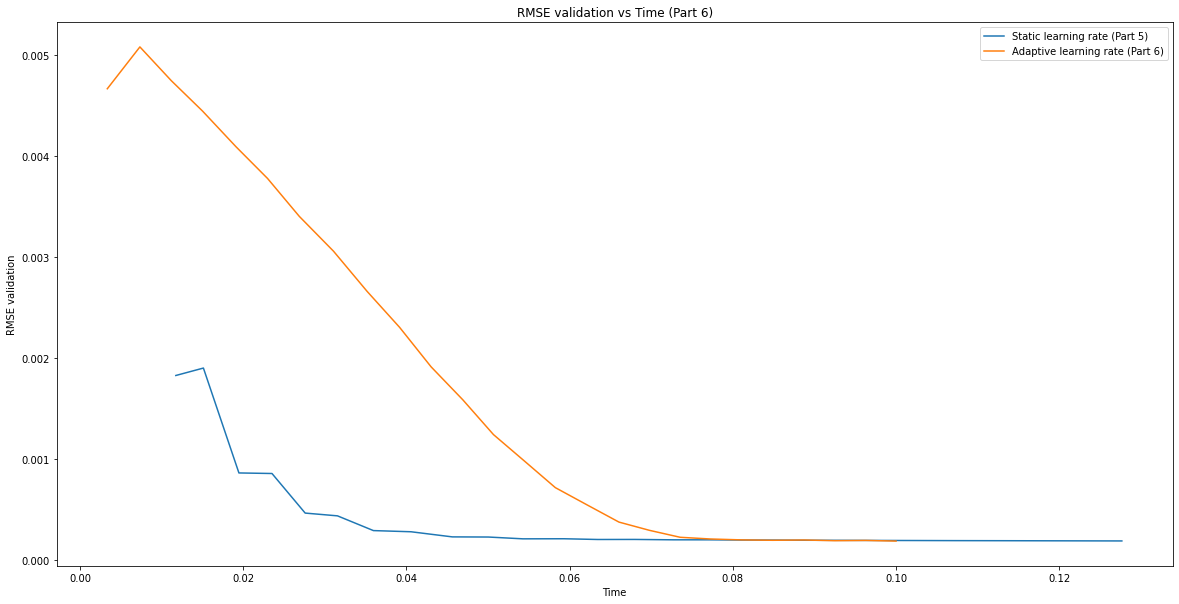

In [ ]:
#Plot the training and validation RMSE vs epoch for your method
plt.figure(figsize=(20,10))
_,_,c1,d1,_,_ = mini_batch_gradient_descent(X_train_new,X_test_new,128,0.015,CT,20000)
plt.plot(d1,c1, label = 'Static learning rate (Part 5)')

_,_,c2,d2,_,_,_ = adaptive_learning_gd(X_train_new,X_test_new,128,lr,CT,20000)
plt.plot(d2,c2, label = 'Adaptive learning rate (Part 6)')
plt.xlabel('Time')
plt.ylabel('RMSE validation')
plt.title('RMSE validation vs Time (Part 6)')
plt.legend()
plt.show

All the plots above prove that the model used for Gradient Descent with Adaptive Learning Rate show faster convergence than the Static Learning rate.

## Part 7 - Gradient Descent with Additional Features and Regularization [3 marks]

Now, we'll apply linear regresssion to a toy dataset (`LR_data.csv`), with 10 features `x1`-`x10` and a "measurement" `y`. We'll take a few shortcuts by using built-in sklearn functions.

1. Data Preparation **[0.5]**
  * Print the dataset, and create Numpy arrays with inputs (X) and outputs (y). 
  * Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.

2. Linear Regression **[0.5]**
  * Standardize the data using StandardScaler from sklearn.
  * Use the `sklearn.linear_model.LinearRegression` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to perform linear regression.
  * Print the RMSE for training and validation data.

3. Linear Regression with Additional Features **[0.5]**
  * Let's add more features to our dataset (up to degree 8) using `sklearn.preprocessing.PolynomialFeatures` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). You'll want to create the additional features first, then perform standardization (start from non-standardized data).
  * Again, use `sklearn.linear_model.LinearRegression` to perform linear regression.
  * Print the RMSE for training and validation data.

4. Linear Regression with Additional Features and Regularization **[0.5]**
  * Let's switch models, and instead use the `sklearn.linear_model.Ridge` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a `FOR` loop to run `sklearn.linear_model.Ridge` with different `alpha` values. Specifically, sweep `alpha` from 1E-2 to 1E10 (each step is an order of magnitude jump).

5. Discuss your results. What do you conclude? **[1]**

####1. Data Preparation

In [ ]:
#Print the dataset
import pandas as pd
df_toy=pd.read_csv("https://www.eecg.utoronto.ca/~hadizade/APS1070/LR_data.csv" , skipinitialspace=True)
print(df_toy.shape)

(200, 11)


In [ ]:
#create Numpy arrays with inputs (X) and outputs (y)
y1 = np.array(df_toy['y'])
X1 = np.array(df_toy.drop(columns=['y']))

In [ ]:
X1.shape

(200, 10)

In [ ]:
#Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set random_state=1
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1) #80:20 split of data

In [ ]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(160, 10)
(40, 10)
(160,)
(40,)


####2. Linear Regression

In [ ]:
#Linear Regression

#Standardize the data using StandardScaler from sklearn.

#Use the xtrain scalar for transforming both the xtest and xtrain @402
#No scaling the targets @380

from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler().fit(X1_train) #fit xtrain to scaler
X1_train_scaled = scaler1.transform(X1_train) #transform xtrain based on scaler
X1_test_scaled = scaler1.transform(X1_test) #transform xtest based on scaler

In [ ]:
#Use the sklearn.linear_model.LinearRegression function here to perform linear regression

Linear_reg = LinearRegression().fit(X1_train_scaled, y1_train)

y1_train_predict_reg = Linear_reg.predict(X1_train_scaled)
y1_test_predict_reg = Linear_reg.predict(X1_test_scaled)

#Print the RMSE for training and validation data

rmse_train = rmse(y1_train_predict_reg,y1_train)
rmse_test = rmse(y1_test_predict_reg,y1_test)

print('RMSE for training data: ',rmse_train)
print('RMSE for validation data: ',rmse_test)

RMSE for training data:  16296980.655667372
RMSE for validation data:  14061578.864980105


####3. Linear Regression with Additional Features

In [ ]:
#Let's add more features to our dataset (up to degree 8) using sklearn.preprocessing.PolynomialFeatures here.

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(8) #initialize the feature change
poly_change = poly.fit(X1_train) #learning the method of transforming training data

X1_train_poly = poly_change.transform(X1_train) #transform x1-train
X1_test_poly = poly_change.transform(X1_test) #transform x2-train

#X1_test_poly

In [ ]:
#You'll want to create the additional features first, then perform standardization (start from non-standardized data).

scaler2 = StandardScaler().fit(X1_train_poly) #fit xtrain-poly to scaler
X1_train_poly_scaled = scaler2.transform(X1_train_poly) #transform xtrain-poly based on scaler2
X1_test_poly_scaled = scaler2.transform(X1_test_poly) #transform xtest-poly based on scaler2

#X1_test_poly_scaled

In [ ]:
#Again, use sklearn.linear_model.LinearRegression to perform linear regression.

Linear_reg_poly = LinearRegression().fit(X1_train_poly_scaled, y1_train)

y1_train_predict_poly_reg = Linear_reg_poly.predict(X1_train_poly_scaled)
y1_test_predict_poly_reg = Linear_reg_poly.predict(X1_test_poly_scaled)

#Print the RMSE for training and validation data.

rmse_train_poly = rmse(y1_train_predict_poly_reg,y1_train)
rmse_test_poly = rmse(y1_test_predict_poly_reg,y1_test)

print('RMSE for training data: ',rmse_train_poly)
print('RMSE for validation data: ',rmse_test_poly)

RMSE for training data:  1.1154878119198678e-07
RMSE for validation data:  10920908.905406754


####4. Linear Regression with Additional Features and Regularization

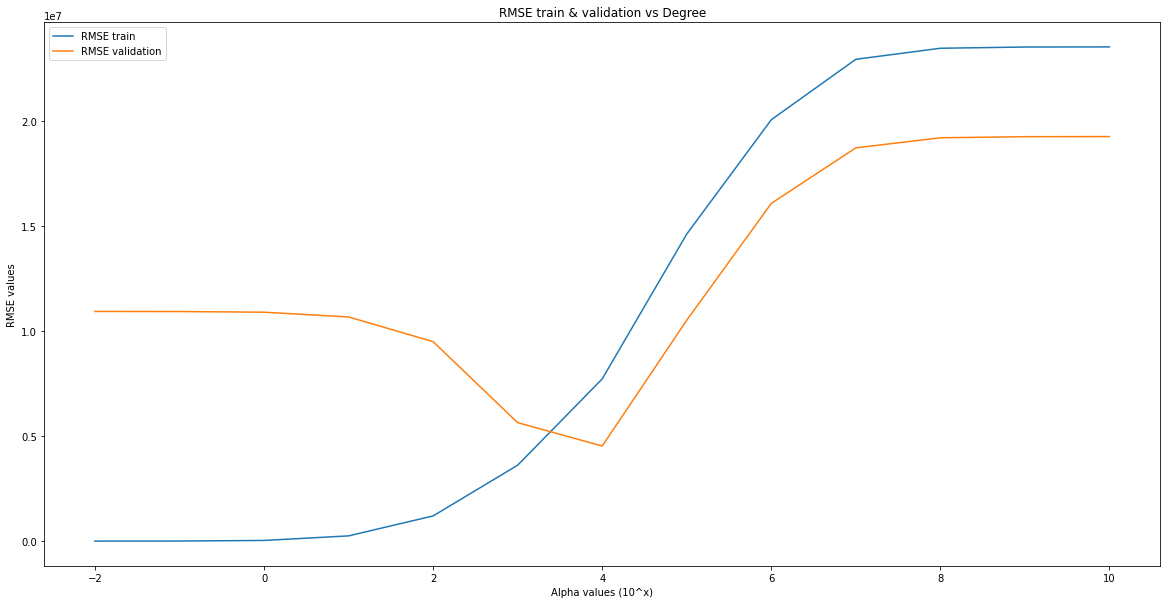

In [ ]:
#Let's switch models, and instead use the sklearn.linear_model.Ridge function here to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a FOR loop to run sklearn.linear_model.Ridge with different alpha values. Specifically, sweep alpha from 1E-2 to 1E10 (each step is an order of magnitude jump).

#from sklearn.linear_model import Ridge

rmse_train_tot = []
rmse_test_tot = []
alpha_val = []

plt.figure(figsize=(20,10))
for i in range(-2,11):
  Ridge_reg_poly = Ridge(alpha=10**i)
  Ridge_model = Ridge_reg_poly.fit(X1_train_poly_scaled, y1_train)

  y1_train_predict_poly_ridge = Ridge_model.predict(X1_train_poly_scaled)
  y1_test_predict_poly_ridge = Ridge_model.predict(X1_test_poly_scaled)

  rmse_train_poly_ridge = rmse(y1_train_predict_poly_ridge,y1_train)
  rmse_test_poly_ridge = rmse(y1_test_predict_poly_ridge,y1_test)

  rmse_train_tot.append(rmse_train_poly_ridge)
  rmse_test_tot.append(rmse_test_poly_ridge)
  alpha_val.append(i)

plt.xlabel('Alpha values (10^x)')
plt.ylabel('RMSE values')
plt.title('RMSE train & validation vs Degree')
plt.plot(alpha_val,rmse_train_tot,label='RMSE train')
plt.plot(alpha_val,rmse_test_tot,label='RMSE validation')
plt.legend()
plt.show()



  

In [ ]:
Ridge_reg_poly = Ridge(alpha=10000)
Ridge_model = Ridge_reg_poly.fit(X1_train_poly_scaled, y1_train)

y1_train_predict_poly_ridge = Ridge_model.predict(X1_train_poly_scaled)
y1_test_predict_poly_ridge = Ridge_model.predict(X1_test_poly_scaled)

rmse_train_poly_ridge = rmse(y1_train_predict_poly_ridge,y1_train)
rmse_test_poly_ridge = rmse(y1_test_predict_poly_ridge,y1_test)

print('RMSE for training data:',rmse_train_poly_ridge)
print('RMSE for validation data:',rmse_test_poly_ridge)

RMSE for training data: 7712389.432217537
RMSE for validation data: 4521905.583502402


####5. Discuss your results. What do you conclude?

<function matplotlib.pyplot.show>

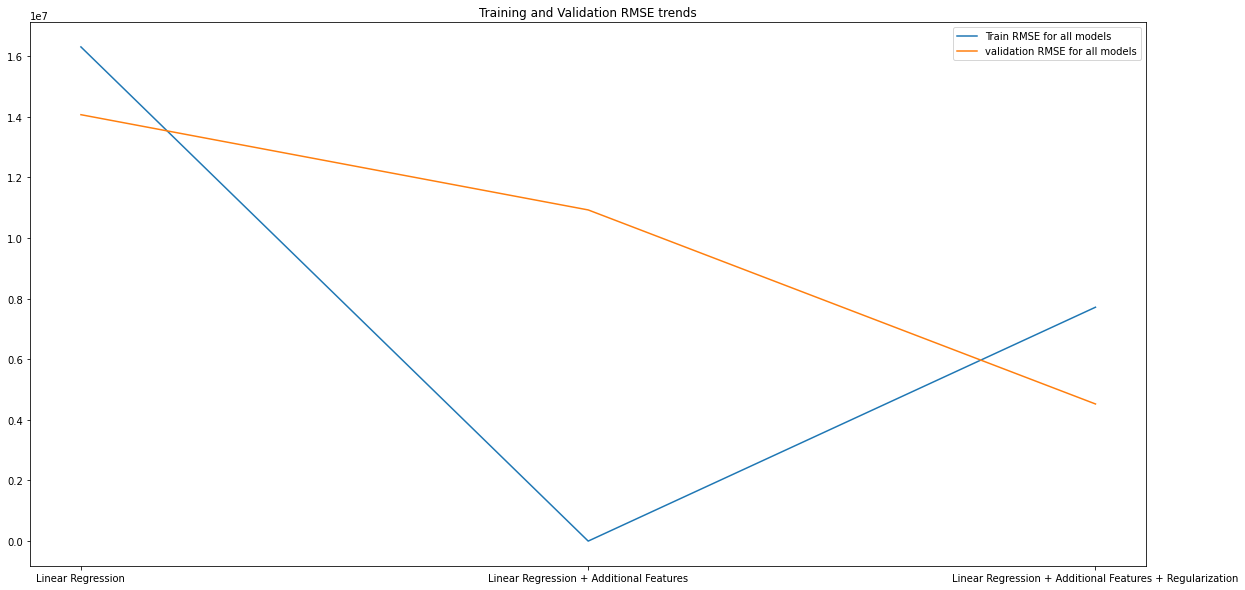

In [ ]:
train_tot = [rmse_train,rmse_train_poly,rmse_train_poly_ridge]
test_tot = [rmse_test,rmse_test_poly,rmse_test_poly_ridge]
mod_n = ['Linear Regression','Linear Regression + Additional Features','Linear Regression + Additional Features + Regularization']
plt.figure(figsize=(20,10))
plt.plot(mod_n,train_tot,label='Train RMSE for all models')
plt.plot(mod_n,test_tot,label='validation RMSE for all models')
plt.title('Training and Validation RMSE trends')
plt.legend()
plt.show


For all the cases the training and testing RMSE is high. This depends on the nature of the dataset. However, the observing the trend is the most important. This exercise can be concluded by looking at the graph above. The trend of the testing RMSE keeps reducing as we make modifications to the original model. The Linear Regression + Additional features model gives better results than simply linear regression model and Linear Regression + Additional features + Regularization model gives better results than Regression + Additional features model.



## Part 8 - Linear Regression with a Custom Dataset [2 marks]


Find a dataset online and train and validate a linear regression model with the techniques you learned in this Project.

*   Introduce your dataset.**[0.5]**
*   Explain your approach. **[0.5]**
*   Summarize your results. **[1]**

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






####1. Introduce your dataset

In [ ]:
df_re=pd.read_csv("US_graduate_schools_admission_parameters_dataset.csv")
df_re.drop(columns=['Serial No.'],inplace=True)
df_re

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1,0.82
396,325,107,3,3.0,3.5,9.11,1,0.84
397,330,116,4,5.0,4.5,9.45,1,0.91
398,312,103,3,3.5,4.0,8.78,0,0.67


This dataset ultimately helps to predict the chance to get an admit to a particular university considering the features shown in the dataframe above. 

In [ ]:
list(df_re.columns)

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR ',
 'CGPA',
 'Research',
 'Chance of Admit ']

In [ ]:
df_re['Chance of Admit ']

0      0.92
1      0.76
2      0.72
3      0.80
4      0.65
       ... 
395    0.82
396    0.84
397    0.91
398    0.67
399    0.95
Name: Chance of Admit , Length: 400, dtype: float64

In [ ]:
#create Numpy arrays with inputs (X) and outputs (y)
y2 = df_re['Chance of Admit ']
X2 = df_re.drop(columns=['Chance of Admit '])
X2

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1
396,325,107,3,3.0,3.5,9.11,1
397,330,116,4,5.0,4.5,9.45,1
398,312,103,3,3.5,4.0,8.78,0


In [ ]:
X2.shape

(400, 7)

In [ ]:
#Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set random_state=1
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=55) #80:20 split of data

In [ ]:
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(320, 7)
(80, 7)
(320,)
(80,)


####2. Explain your approach

The original data gets pre-processed and standardized so that it can used as an input to a regression model. Linear Regression model is used without regularization. 

In [ ]:
#Linear Regression

#Standardize the data using StandardScaler from sklearn.

#Use the xtrain scalar for transforming both the xtest and xtrain @402
#No scaling the targets @380

from sklearn.preprocessing import StandardScaler
scaler3 = StandardScaler().fit(X2_train) #fit xtrain to scaler
X2_train_scaled = scaler3.transform(X2_train) #transform xtrain based on scaler
X2_test_scaled = scaler3.transform(X2_test) #transform xtest based on scaler

In [ ]:
#Method 1 - Linear Regression
#Use the sklearn.linear_model.LinearRegression function here to perform linear regression

Linear_reg = LinearRegression().fit(X2_train_scaled, y2_train)

y2_train_predict_reg = Linear_reg.predict(X2_train_scaled)
y2_test_predict_reg = Linear_reg.predict(X2_test_scaled)

#Print the RMSE for training and validation data

rmse_train2 = rmse(y2_train_predict_reg,y2_train)
rmse_test2 = rmse(y2_test_predict_reg,y2_test)

print('RMSE for training data: ',rmse_train2)
print('RMSE for validation data: ',rmse_test2)

RMSE for training data:  0.06343943339319237
RMSE for validation data:  0.06244014912879836


####3. Summarize your results.

Linear Regression is a good model for this dataset.

1. The training and validation RMSE is pretty low.
2. Due to point 1, it is a good fit to the training data (good predictive performance).
3. Regularization doesn't help to reduce the validation RMSE further as the RMSE's are already pretty low.